https://www.kaggle.com/c/dog-breed-identification/submissions?sortBy=date&group=all&page=1  
kaggle competitions submit -c dog-breed-identification -f submission.csv -m "Message"  
cd ~/.kaggle/competitions/dog-breed-identification/  
ls  
#labels.csv.zip  sample_submission.csv.zip  test.zip  train.zip  
unzip -l train.zip   
unzip train.zip -d ~/kaggleData/dogBreeds/  
unzip test.zip -d ~/kaggleData/dogBreeds/  
unzip sample_submission.csv.zip -d ~/kaggleData/dogBreeds/  
unzip labels.csv.zip -d ~/kaggleData/dogBreeds/  
cd ~/kaggleData/dogBreeds/  

In [1]:
import timeit
notebook_start_time = timeit.default_timer()

In [2]:
FASTHOME = "/home/ec2-user/fastai/"
DATADIR = "/home/ec2-user/kaggleData/dogBreeds/"
TESTDIR = DATADIR + "test"
TRAINDIR = DATADIR + "train"
label_csv = f'{DATADIR}labels.csv'
print ("label_csv:", label_csv)

label_csv: /home/ec2-user/kaggleData/dogBreeds/labels.csv


In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import sys 
from sklearn import metrics
print ("cwd:", os.getcwd()) 
print (sys.version_info)

cwd: /home/ec2-user/kaggle/dogBreed
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [5]:
import torch, cv2

In [6]:
# This file contains all the main external libs we'll use
os.chdir(FASTHOME)
print (os.getcwd())
from fastai.imports import *

/home/ec2-user/fastai


In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [8]:
arch=resnext101_64 #from fastai or pytorch?
print ("arch:", type(arch))
#https://github.com/facebookresearch/ResNeXt
#lecture mentions resnext50 @ 1:50
#had to reduce batch size from 58 to 28 for an 11GB GPU memory.
sz = 500 #was originall 224
bs = 58

arch: <class 'function'>


In [9]:
os.chdir(DATADIR)
os.getcwd()

'/home/ec2-user/kaggleData/dogBreeds'

In [10]:

n = len(list(open(label_csv)))-1
print ("n:", n, ", n x 20% = ", 0.2*n)
val_idxs = get_cv_idxs(n) #get_cv_idxs is from fastai library : cross validation - randomly selects train/valid split.
print ("val_idxs:", type(val_idxs), len(val_idxs), val_idxs[0:5])

n: 10222 , n x 20% =  2044.4
val_idxs: <class 'numpy.ndarray'> 2044 [2882 4514 7717   33 4924]


In [11]:
!ls {DATADIR}

dogbreed_submit2.csv  labels.csv  sample_submission.csv  tmp
dogbreed_submit.csv   models	  test			 train


In [12]:
label_df = pd.read_csv(label_csv)
print ("label_df:", label_df.shape)

label_df: (10222, 2)


In [13]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
print ("column names:", list(label_df))
breeds = label_df['breed'].unique()
print (type(breeds), breeds.shape)
breeds

column names: ['id', 'breed']
<class 'numpy.ndarray'> (120,)


array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi',
       'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier',
       'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel',
       'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle',
       'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke',
       'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer',
       'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malam

In [15]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom = 1.1)
print (type(tfms))
data = ImageClassifierData.from_csv(DATADIR, 'train', 
                                    label_csv, 
                                    test_name = 'test', 
                                    val_idxs=val_idxs, 
                                    suffix='.jpg', 
                                    tfms=tfms, 
                                    bs=bs)

<class 'tuple'>


In [17]:
#dir(data)
#hide for brevity.

In [18]:
print ("Validation:", type(data.val_ds.y), data.val_ds.y.shape, data.val_ds.y[0:5])
print ("No of diff classes: ", np.unique(data.val_ds.y).shape[0])
print ("Train:", type(data.trn_ds.y), data.trn_ds.y.shape, data.trn_ds.y[0:5])
print ("No of diff classes: ", np.unique(data.trn_ds.y).shape[0])
print ("Test:", type(data.test_ds.y), data.test_ds.y.shape)
#note: test values are different because test data does not have an input class.
print ()

print ("Validation:", type(data.val_ds.fnames), data.val_ds.fnames.shape, data.val_ds.fnames[0])
print ("Train:", type(data.trn_ds.fnames), data.trn_ds.fnames.shape, data.trn_ds.fnames[0])
print ("Test:", type(data.test_ds.fnames), len(data.test_ds.fnames), data.test_ds.fnames[0])
#note: test values are different because test data does not have an input class.

Validation: <class 'numpy.ndarray'> (2044,) [19 15  7 99 73]
No of diff classes:  120
Train: <class 'numpy.ndarray'> (8178,) [37 85 49 10 10]
No of diff classes:  120
Test: <class 'numpy.ndarray'> (10357, 1)

Validation: <class 'numpy.ndarray'> (2044,) train/000bec180eb18c7604dcecc8fe0dba07.jpg
Train: <class 'numpy.ndarray'> (8178,) train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
Test: <class 'list'> 10357 test/09fddf304d2789cfbb55935237dbac13.jpg


In [19]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(DATADIR, 'train', 
                                    label_csv, 
                                    test_name = 'test', 
                                    num_workers = 4,
                                    val_idxs=val_idxs, 
                                    suffix='.jpg', 
                                    tfms=tfms, 
                                    bs=bs)
    return data if sz>300 else data.resize(340, "tmp")

In [20]:
#nb: use get_data(sz, bs) to enable easily loading different size images. ie: initally load w sz=64 to run fast.
# then load with sz = larger numbers up to 600 to get better accuracy
# if CUDA out of memory error then restart kernel
# then need to make batch size smaller.

In [21]:
%%time
data = get_data(sz, bs)

CPU times: user 236 ms, sys: 12 ms, total: 248 ms
Wall time: 245 ms


In [22]:
print ("Validation:", type(data.val_ds.y), data.val_ds.y.shape, data.val_ds.y[0:5])
print ("No of diff classes: ", np.unique(data.val_ds.y).shape[0])
print ("Train:", type(data.trn_ds.y), data.trn_ds.y.shape, data.trn_ds.y[0:5])
print ("No of diff classes: ", np.unique(data.trn_ds.y).shape[0])
print ("Test:", type(data.test_ds.y), data.test_ds.y.shape)
#note: test values are different because test data does not have an input class.
print ()

print ("Validation:", type(data.val_ds.fnames), data.val_ds.fnames.shape, data.val_ds.fnames[0])
print ("Train:", type(data.trn_ds.fnames), data.trn_ds.fnames.shape, data.trn_ds.fnames[0])
print ("Test:", type(data.test_ds.fnames), len(data.test_ds.fnames), data.test_ds.fnames[0])
#note: test values are different because test data does not have an input class.

Validation: <class 'numpy.ndarray'> (2044,) [19 15  7 99 73]
No of diff classes:  120
Train: <class 'numpy.ndarray'> (8178,) [37 85 49 10 10]
No of diff classes:  120
Test: <class 'numpy.ndarray'> (10357, 1)

Validation: <class 'numpy.ndarray'> (2044,) train/000bec180eb18c7604dcecc8fe0dba07.jpg
Train: <class 'numpy.ndarray'> (8178,) train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
Test: <class 'list'> 10357 test/09fddf304d2789cfbb55935237dbac13.jpg


In [23]:
%%time
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.5)

100%|██████████| 179/179 [29:43<00:00,  9.96s/it]
CPU times: user 58min 46s, sys: 5min 35s, total: 1h 4min 21s
Wall time: 59min 7s


In [24]:
%%time
#learn.fit(1e-2, 5, cycle_len = 1, cycle_mult=2)
learn.fit(1e-2, 5, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.225435   1.403689   0.788519  
    1      1.125397   0.697678   0.875889                   
    2      0.775702   0.508254   0.896483                    
    3      0.604749   0.431529   0.896962                    
    4      0.51052    0.381292   0.900794                    

CPU times: user 20 s, sys: 11.3 s, total: 31.3 s
Wall time: 16.2 s


[0.38129172, 0.9007936484283872]

#original code and results
sz = 224
learn.fit(1e-2, 5, cycle_len = 1)
epoch      trn_loss   val_loss   accuracy                   
    0      1.145816   0.42161    0.908525  
    1      0.533597   0.301712   0.918103                    
    2      0.364091   0.276494   0.918582                    
    3      0.299081   0.257694   0.923372                    
    4      0.253118   0.246878   0.926724     
#2nd run
learn.fit(1e-2, 5, cycle_len = 1) w sz = 500

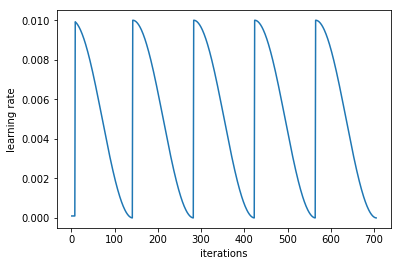

In [25]:
learn.sched.plot_lr()

In [26]:
#learn.sched.plot()
#AttributeError: 'CosAnneal' object has no attribute 'plot'

In [27]:
#learn.save("224_pre")
#learn.load("224_pre")

In [28]:
#refer lecture 1:33, add data after initial training
#increase size of images

In [29]:
learn.set_data(get_data(299, bs))
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [30]:
%%time
#learn.fit(1e-2, 5, cycle_len=1, cycle_mult=2)
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.449268   0.35692    0.898878  
    1      0.395984   0.343116   0.90223                     
    2      0.349762   0.329248   0.908046                    
    3      0.33004    0.324916   0.906062                    
    4      0.290809   0.316187   0.906541                    

CPU times: user 19.9 s, sys: 11.2 s, total: 31.1 s
Wall time: 16 s


[0.31618708, 0.9065407779481676]

# val_loss =0.22 cf trn_loss=0.28, room to improve as still underfitting 
epoch      trn_loss   val_loss   accuracy                     
    0      0.323929   0.231236   0.927203  
    1      0.319042   0.228883   0.926724                    
    2      0.278326   0.22305    0.931513                    

CPU times: user 33min 38s, sys: 3min 16s, total: 36min 55s  
Wall time: 29min 48s  

In [31]:
#start training on smaller images, then train again on larger images. avoids overfitting.
#needs paper published on fully convolutional networks. not using vgg.refer lecture @ 1:34

#precompute off
#nb: losses in training set are higher than losses in validation set = underfitting.
#do more fitting until losses training ~ losses validation

In [32]:
%%time
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.270436   0.31008    0.909483  
    1      0.256461   0.303322   0.904693                    
    2      0.216458   0.298213   0.911398                    
    3      0.225089   0.307874   0.904146                    
    4      0.197825   0.297466   0.905651                    
    5      0.181584   0.294158   0.905651                    
    6      0.162631   0.293726   0.906609                    

CPU times: user 28.1 s, sys: 15.8 s, total: 43.9 s
Wall time: 22.6 s


[0.2937257, 0.9066091974576315]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 104/141 [00:02<00:00, 40.55it/s, loss=0.619]


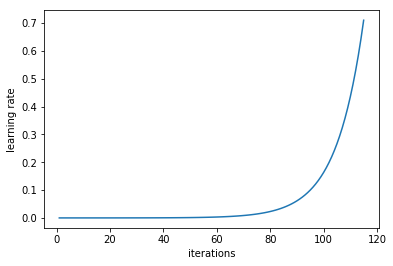

In [33]:
learn.lr_find()
learn.sched.plot_lr()

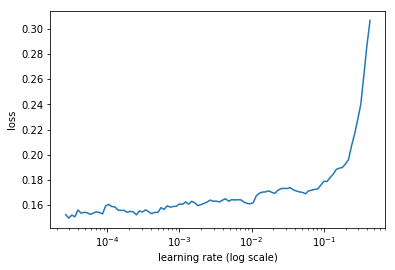

In [34]:
learn.sched.plot()

In [35]:
%%time
log_preds, y = learn.TTA()
#probs = np.exp(log_preds)#superceded by update to fastai/metrics.py
#refer video @ 1:36

CPU times: user 3.24 s, sys: 2.05 s, total: 5.29 s
Wall time: 2.5 s


In [36]:
#refer forum post
#http://forums.fast.ai/t/lesson1-ipynb-error-typeerror-torch-max-received-an-invalid-combination-of-arguments-got-numpy-ndarray-dim-int/10707/6
probs = np.mean(np.exp(log_preds),0)
print ("accuracy_np(probs, y):", accuracy_np(probs, y))
print ("metrics.log_loss(y, probs):", metrics.log_loss(y, probs))

accuracy_np(probs, y): 0.9045988258317026
metrics.log_loss(y, probs): 0.29777092864775523


In [37]:
#learn.save("299_pre")
#learn.load("299_pre")

In [38]:
%%time
learn.fit(1e-2, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.178365   0.287434   0.90613   
    1      0.151809   0.287336   0.908525                    

CPU times: user 8.21 s, sys: 4.52 s, total: 12.7 s
Wall time: 6.55 s


[0.28733647, 0.9085249089532428]

In [39]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 111/141 [00:02<00:00, 44.00it/s, loss=0.562]


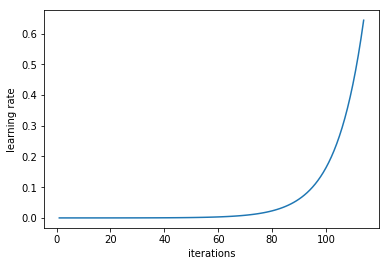

In [40]:
learn.sched.plot_lr()

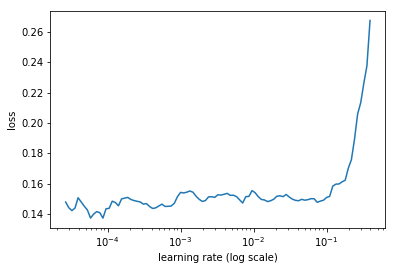

In [41]:
learn.sched.plot()

In [42]:
#learn.save("299b_pre")
#learn.load("299b_pre")

In [43]:
#NB: did not unfreeze and retrain all layers. 
#dataset is very similar to imagenet.

In [44]:
%%time
log_preds, y = learn.TTA()
#probs = np.exp(log_preds)
#print ("accuracy:", accuracy(log_preds, y))
#print ("metrics.log_loss(y, probs):", metrics.log_loss(y, probs))

CPU times: user 3.22 s, sys: 2.06 s, total: 5.27 s
Wall time: 2.5 s


In [45]:
probs = np.mean(np.exp(log_preds),0)
print ("accuracy_np(probs, y):", accuracy_np(probs, y))
print ("metrics.log_loss(y, probs):", metrics.log_loss(y, probs))

accuracy_np(probs, y): 0.9065557729941291
metrics.log_loss(y, probs): 0.29156959258261095


In [46]:
#to improve accuracy rerun the training on the whole dataset, without removing some data to validation.
#use validation data to tune models. use whole dataset to optimise accuracy. 

In [47]:
print (type(y), y.shape)
print (y[0:5])
np.unique(y)

<class 'numpy.ndarray'> (2044,)
[19 15  7 99 73]


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

In [48]:
#learn.save("299c_pre")

In [49]:
%%time
test_pred = learn.predict(is_test=True) 

CPU times: user 3.24 s, sys: 2.14 s, total: 5.38 s
Wall time: 2.53 s


In [50]:
print (type(test_pred), test_pred.shape)

<class 'numpy.ndarray'> (10357, 120)


In [51]:
notebook_end_time = timeit.default_timer()
notebook_duration = divmod(notebook_end_time-notebook_start_time, 60)
print ("notebook total execute time: ", notebook_duration)
print("notebook total execute time: %d minutes, %d seconds." % (notebook_duration[0], notebook_duration[1]))

notebook total execute time:  (60.0, 26.04526067400002)
notebook total execute time: 60 minutes, 26 seconds.


In [52]:
print ("test_pred:", type(test_pred), test_pred.shape)
print ("--------------")
print (test_pred[0, :])#nb: need to convert from exp to logs?
print ("--------------")
test_pred_ = np.exp(test_pred)
print ("test_pred_:", type(test_pred_), test_pred_.shape)
print (test_pred_[0, :])

test_pred: <class 'numpy.ndarray'> (10357, 120)
--------------
[-13.8618  -15.79361 -14.51625 -10.38942 -13.59686  -9.46904 -14.59811 -14.27796 -15.96538 -15.54298
 -16.95124 -12.71411  -4.83762 -18.07962 -13.08204 -13.57573 -15.97442 -15.29214 -16.79227 -15.26288
 -13.33826 -13.3575  -11.31058 -14.3183  -16.66533 -13.47946 -17.35032 -15.89702 -13.87141 -16.42372
 -12.45137 -17.74388 -18.19462 -15.77526 -13.10864 -16.25246 -15.12066 -17.25919  -4.96329 -14.26271
 -17.55602 -17.94263  -7.52937 -15.36324 -14.0227  -17.59389 -11.35159 -15.39882 -13.11913 -16.87529
  -7.73365 -13.77323 -16.05633  -9.08209 -15.03587 -18.07455 -15.6956  -13.4158  -15.29875 -14.82961
 -17.00927 -14.96196 -14.14752  -9.04321 -17.08721 -15.79655 -15.06063 -11.0762  -15.62757 -15.40756
 -17.40944 -15.24365 -15.62774 -15.51982 -17.00534 -10.67319 -17.99575 -14.45658 -14.48335 -16.37867
 -14.37214 -16.97818 -15.58971 -14.19967 -16.62712 -16.27156 -15.14112 -16.91179 -15.28364 -13.58804
 -11.72982  -0.01667 -14.376

In [53]:
test_pred_categories = np.argmax(test_pred, axis=1)
#index of the predicted categories 
print ("test_pred_categories:", type(test_pred_categories), test_pred_categories.shape, len(np.unique(test_pred_categories)))
test_pred_categories[0:5]

test_pred_categories: <class 'numpy.ndarray'> (10357,) 120


array([91, 83,  3, 52, 13])

In [54]:
#data.test_ds.y explore data.test_ds for filename 
#dir(data.test_ds)
type(data.test_ds.fnames), len(data.test_ds.fnames), data.test_ds.fnames[0].split("/")[1].split(".")[0]
#need to strip test/ from fnames : use split('/')[1]

(list, 10357, '09fddf304d2789cfbb55935237dbac13')

In [55]:
ids = [fname.split("/")[1].split(".")[0] for fname in data.test_ds.fnames]
print("ids:", type(ids), len(ids), ids[0:5])

ids: <class 'list'> 10357 ['09fddf304d2789cfbb55935237dbac13', '71d74387ba7dd965b5aebae6a01a11f9', 'b8d550702cb5ea905cc02af8c3e152f7', '80772a2c72d253b2834b6975db3f6cc7', 'eb9e89f5c0f1717f290360fec6f2a160']


In [56]:
# assemble fname and predicted breed into submission file format.
# submission file format is 
# header row = id, followed by names of all breeds.
# where id = filename without suffice or prefix.
# subsequent rows are id, followed by probability of each breed in float format. 
# ie "0.00833333333333333" 17 decimal places

#create dataframe by combining ids (list) as column 0 with test_pred_ (numpy.ndarray)


In [57]:
type(list(breeds))

list

In [58]:
type(test_pred_), test_pred_.shape

(numpy.ndarray, (10357, 120))

In [59]:
type(np.array(ids)), np.array(ids).shape

(numpy.ndarray, (10357,))

In [60]:
df1 = pd.DataFrame(ids)
df1.columns = ['id']
print (df1.shape, list(df1))

(10357, 1) ['id']


In [61]:
df2 = pd.DataFrame(test_pred_)
df2.columns = list(breeds)
df2 = df2.reindex(sorted(df2.columns), axis=1)
print (df2.shape, list(df2))

(10357, 120) ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_te

In [62]:
df = pd.concat([df1, df2], axis=1)
print (df.shape)
df.head(2)

(10357, 121)


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09fddf304d2789cfbb55935237dbac13,5.785505e-08,4.117879e-08,1.406436e-08,1.181907e-04,1.633168e-07,1.175078e-05,0.000537,6.297406e-07,1.612926e-08,...,1.253652e-08,4.231256e-08,1.762821e-08,4.346809e-08,9.456357e-07,0.000001,0.000001,9.751226e-08,0.000002,3.719387e-07
1,71d74387ba7dd965b5aebae6a01a11f9,8.365393e-08,1.292187e-06,2.402101e-07,1.231491e-07,2.355177e-06,1.576035e-07,0.000001,1.089495e-07,2.470919e-08,...,9.488743e-07,3.817541e-05,2.203151e-07,2.870880e-06,1.344400e-06,0.000105,0.000045,5.672177e-07,0.000009,1.740025e-06


In [63]:
list(df)

['id',
 'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenen

In [64]:
os.getcwd()

'/home/ec2-user/kaggleData/dogBreeds'

In [65]:
df.to_csv(DATADIR+'dogbreed_submit3.csv',index=False)

In [66]:
#!kaggle competitions submit -c dog-breed-identification -f /home/ec2-user/kaggleData/dogBreeds/dogbreed_submit3.csv -m "third submission"

In [67]:
#kaggle score = 13.32251

In [68]:
!ls

dogbreed_submit2.csv  dogbreed_submit.csv  models		  test	train
dogbreed_submit3.csv  labels.csv	   sample_submission.csv  tmp


In [69]:
!pwd


/home/ec2-user/kaggleData/dogBreeds
